# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

We're using TF 1.2.1


<module 'grading_utils' from '/home/jovyan/work/week2/v2/grading_utils.py'>

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [97]:
# token expires every 30 min
COURSERA_TOKEN = 'WesWKSrpyE9hmU5U'
COURSERA_EMAIL = 'sangarshanan@gmail.com'

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

Using TensorFlow backend.


11304960/11490434 [============================>.] - ETA: 0s

X_train [shape (50000, 28, 28)] sample patch:
 [[ 0.          0.29803922  0.96470588  0.98823529  0.43921569]
 [ 0.          0.33333333  0.98823529  0.90196078  0.09803922]
 [ 0.          0.33333333  0.98823529  0.8745098   0.        ]
 [ 0.          0.33333333  0.98823529  0.56862745  0.        ]
 [ 0.          0.3372549   0.99215686  0.88235294  0.        ]]
A closeup of a sample patch:


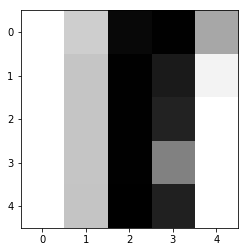

And the whole sample:


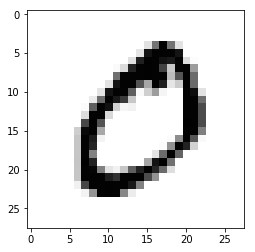

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [66]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [67]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [68]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]] [5 0 4]


In [69]:
y_train.shape

(50000,)

In [70]:
# run this if you remake your graph
tf.reset_default_graph()

In [71]:
X_train.shape[1]

28

In [79]:
W = tf.get_variable("W", shape=(784,10), dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable("b", shape=(10,), dtype = tf.float32, initializer = tf.contrib.layers.xavier_initializer())

In [80]:
input_X = tf.placeholder(tf.float32, shape=(None,784))
input_y = tf.placeholder(tf.float32, shape=(None,10))

In [81]:
logits = tf.matmul(input_X, W) + b
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))
step = tf.train.AdamOptimizer().minimize(loss)

In [82]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

# Submit a linear model

In [83]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [84]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Adding more layers

Let's add a couple of hidden layers and see how that improves our validation accuracy.

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convinient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (rememeber that we need it for a hidden layer!).

Now add 2 hidden layers to the code above and restart training.
You're aiming for ~0.97 validation accuracy here.

In [93]:
# you can write the code here to get a new `step` operation and then run cells with training loop above
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety
### YOUR CODE HERE ###


hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))
step = tf.train.AdamOptimizer().minimize(loss)

In [94]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

# Submit a 2-layer MLP
Run these cells after training a 2-layer MLP

In [98]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [99]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
